In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
df = pd.read_csv("./credit_risk_dataset_red_ml_ord_scaled.csv")

In [38]:
df.describe()
len(df.columns)

20

In [39]:
df.sample(2)

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
1413,0.34,0.012735,0.129032,0.333333,0.275362,0.501498,1.0,0.436620,0.0,0.428571,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
612,0.08,0.021191,0.000000,0.000000,0.159420,0.333733,0.0,0.183099,0.0,0.035714,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [40]:
y = df['loan_status']
y

0       0.0
1       1.0
2       0.0
3       0.0
4       0.0
       ... 
2995    0.0
2996    0.0
2997    0.0
2998    0.0
2999    0.0
Name: loan_status, Length: 3000, dtype: float64

In [41]:
X = df.drop(columns = ['loan_status'])

In [42]:
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# x è il tuo DataFrame delle feature
# x = df_numeric.drop(columns='loan_status')

# scaler da 0 a 2π
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))

# fit sul dataset e trasformazione
X_scaled = scaler.fit_transform(X)   # shape: (n_samples, n_features)

In [43]:
from qiskit.circuit.library import z_feature_map
# remember we need to divide by 2

In [44]:
import numpy as np
from qiskit.circuit.library import EfficientSU2

def build_su2_encoder(x_features, num_qubits=2, reps=1):
    """
    x_features : array-like con le tue feature (es. 7 valori in [0, 2π])
    Restituisce un circuito SU2 già BINDATO (senza parametri simbolici).
    """
    circuit = EfficientSU2(num_qubits=num_qubits,
                           reps=reps,
                           insert_barriers=True)

    n_params = circuit.num_parameters
    x = np.array(x_features, dtype=float)

    # padding / taglio per far combaciare dimensioni
    if len(x) < n_params:
        x = np.pad(x, (0, n_params - len(x)), constant_values=0.0)
    elif len(x) > n_params:
        x = x[:n_params]

    # binding parametri → valori numerici
    param_list = list(circuit.parameters)
    binding = {param_list[i]: x[i] for i in range(n_params)}
    encoder_bound = circuit.assign_parameters(binding)
    # circuit.barrier()

    return encoder_bound

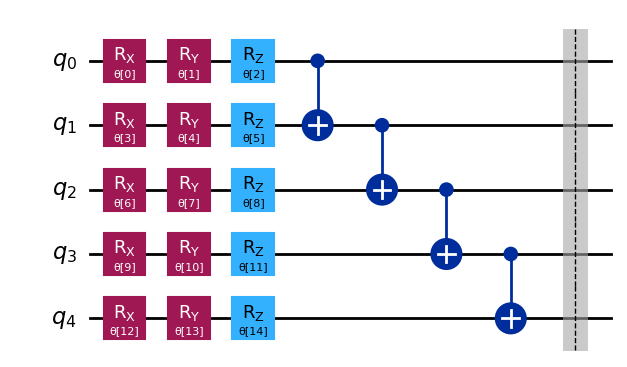

In [45]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

n_qubits = 5
reps = 1  # number of layers
theta = ParameterVector("θ", length=3 * n_qubits * reps)

qnn_ansatz = QuantumCircuit(n_qubits)
param_idx = 0

for layer in range(reps):
    # Single-qubit rotations for this layer
    for i in range(n_qubits):
        qnn_ansatz.rx(theta[param_idx], i)
        qnn_ansatz.ry(theta[param_idx + 1], i)
        qnn_ansatz.rz(theta[param_idx + 2], i)
        param_idx += 3

    # Ladder entanglement with increasing spacing
    spacing = layer + 1  # progressive spacing
    for i in range(n_qubits - spacing):
        qnn_ansatz.cx(i, i + spacing)
    qnn_ansatz.barrier()

qnn_ansatz.draw("mpl")

/tmp/ipykernel_78617/3221270340.py:9: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  circuit = EfficientSU2(num_qubits=num_qubits,


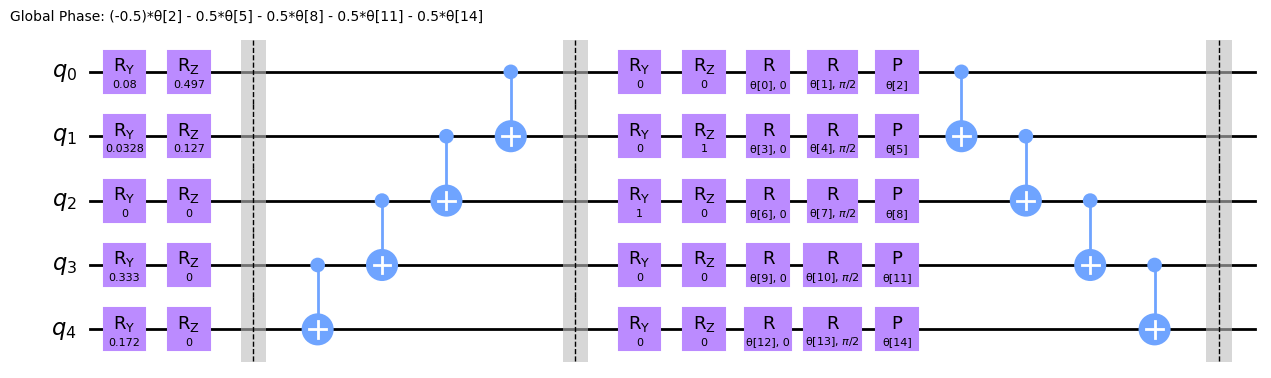

In [46]:
# QNN ansatz
ansatz = qnn_ansatz

encoder = build_su2_encoder(X.iloc[0].to_numpy(), num_qubits = 5, reps = 1)

# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(5)
full_circuit.compose(encoder, range(n_qubits), inplace=True)
full_circuit.compose(ansatz, range(n_qubits), inplace=True)
 
# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

In [47]:
from qiskit.quantum_info import SparsePauliOp
 
observable = SparsePauliOp.from_list([("Z" * (n_qubits), 1)])

In [48]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
 
 
def forward(
    circuit: QuantumCircuit,
    input_params: np.ndarray,
    weight_params: np.ndarray,
    estimator: BaseEstimatorV2,
    observable: BaseOperator,
) -> np.ndarray:
    """
    Forward pass of the neural network.
 
    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive.
        observable: a single observable to compute the expectation over.
 
    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    #params = np.concatenate((input_params, weights), axis=1)
    params = weights
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
 
    return expectation_values

In [49]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).
 
    prediction: predictions from the forward pass of neural network.
    target: true labels.
 
    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError("input should be 1d-array")

In [50]:
def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.
 
    weight_params: ansatz parameters to be updated by the optimizer.
 
    output: MSE loss.
    """
    predictions = forward(
        circuit=circuit,
        input_params=input_params,
        weight_params=weight_params,
        estimator=estimator,
        observable=observable,
    )
 
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)
 
    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1
 
    return cost

In [51]:
from scipy.optimize import minimize

In [52]:
# Globals
circuit = full_circuit
observables = observable
# input_params = train_images_batch
# target = train_labels_batch
objective_func_vals = []
iter = 0

In [53]:
len(ansatz.parameters)

15

In [54]:
from qiskit.primitives import StatevectorEstimator as Estimator
 
batch_size = 100
num_epochs = 1
num_samples = len(X)
 
# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0
 
# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
 
for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(X_scaled[start_i:end_i])
        train_labels_batch = np.array(y[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(
            mse_loss_weights, weight_params, method="COBYLA", options={"maxiter": 100}
        )
        weight_params = res["x"]

Epoch: 0, batch: 0
Iter: 0, loss: 0.1956773361537157
Iter: 50, loss: 0.1659003229516542
Epoch: 0, batch: 1
Iter: 0, loss: 0.17749998834112035
Iter: 50, loss: 0.17710450256160035
Epoch: 0, batch: 2
Iter: 0, loss: 0.16629999009149907
Iter: 50, loss: 0.16590001199574445
Epoch: 0, batch: 3
Iter: 0, loss: 0.16009999542151288
Iter: 50, loss: 0.1600000478979563
Epoch: 0, batch: 4
Iter: 0, loss: 0.1479994565489143
Iter: 50, loss: 0.14760044987917964
Epoch: 0, batch: 5
Iter: 0, loss: 0.13479999932442094
Iter: 50, loss: 0.13440268242070338
Epoch: 0, batch: 6
Iter: 0, loss: 0.14799909541998033
Iter: 50, loss: 0.14760000001164705
Epoch: 0, batch: 7
Iter: 0, loss: 0.16680002220588303
Iter: 50, loss: 0.1659147501901916
Epoch: 0, batch: 8
Iter: 0, loss: 0.17750000302021335
Iter: 50, loss: 0.1771123907213975
Epoch: 0, batch: 9
Iter: 0, loss: 0.19330022144683948
Iter: 50, loss: 0.19240028967608608
Epoch: 0, batch: 10
Iter: 0, loss: 0.15879946184267613
Iter: 50, loss: 0.1539000806127095
Epoch: 0, batch:

In [56]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer
 
estimator = Estimator()
# estimator = Estimator(backend=backend)
 
pred_train = forward(circuit, np.array(X_scaled), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)
 
print(pred_train)
 
pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(y)
 
accuracy = accuracy_score(y, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[0.22000026 0.22000026 0.22000026 ... 0.22000026 0.22000026 0.22000026]
[1. 1. 1. ... 1. 1. 1.]
0       0.0
1       1.0
2       0.0
3       0.0
4       0.0
       ... 
2995    0.0
2996    0.0
2997    0.0
2998    0.0
2999    0.0
Name: loan_status, Length: 3000, dtype: float64
Train accuracy: 21.8%
